In [1]:
import itertools
import os
import os.path as osp
import pickle
import urllib
from collections import namedtuple

import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.nn import Linear 

import pandas as pd
%matplotlib inline

In [2]:
Data = namedtuple('Data', ['x', 'y', 'adjacency',
                           'train_mask', 'val_mask', 'test_mask'])


def tensor_from_numpy(x, device):
    return torch.from_numpy(x).to(device)


class CoraData(object):
    filenames = ["ind.cora.{}".format(name) for name in
                 ['x', 'tx', 'allx', 'y', 'ty', 'ally', 'graph', 'test.index']]

    def __init__(self, data_root="../data/cora", rebuild=False):
        """Cora数据，包括数据下载，处理，加载等功能
        当数据的缓存文件存在时，将使用缓存文件，否则将下载、进行处理，并缓存到磁盘

        处理之后的数据可以通过属性 .data 获得，它将返回一个数据对象，包括如下几部分：
            * x: 节点的特征，维度为 2708 * 1433，类型为 np.ndarray
            * y: 节点的标签，总共包括7个类别，类型为 np.ndarray
            * adjacency: 邻接矩阵，维度为 2708 * 2708，类型为 scipy.sparse.coo.coo_matrix
            * train_mask: 训练集掩码向量，维度为 2708，当节点属于训练集时，相应位置为True，否则False
            * val_mask: 验证集掩码向量，维度为 2708，当节点属于验证集时，相应位置为True，否则False
            * test_mask: 测试集掩码向量，维度为 2708，当节点属于测试集时，相应位置为True，否则False

        Args:
        -------
            data_root: string, optional
                存放数据的目录，原始数据路径: ../data/cora
                缓存数据路径: {data_root}/ch5_cached.pkl
            rebuild: boolean, optional
                是否需要重新构建数据集，当设为True时，如果存在缓存数据也会重建数据

        """
        self.data_root = data_root
        save_file = osp.join(self.data_root, "ch5_cached.pkl")
        if osp.exists(save_file) and not rebuild:
            print("Using Cached file: {}".format(save_file))
            self._data = pickle.load(open(save_file, "rb"))
        else:
            self._data = self.process_data()
            with open(save_file, "wb") as f:
                pickle.dump(self.data, f)
            print("Cached file: {}".format(save_file))
    
    @property
    def data(self):
        """返回Data数据对象，包括x, y, adjacency, train_mask, val_mask, test_mask"""
        return self._data

    def process_data(self):
        """
        处理数据，得到节点特征和标签，邻接矩阵，训练集、验证集以及测试集
        引用自：https://github.com/rusty1s/pytorch_geometric
        """
        print("Process data ...")
        _, tx, allx, y, ty, ally, graph, test_index = [self.read_data(
            osp.join(self.data_root, name)) for name in self.filenames]
        train_index = np.arange(y.shape[0])
        val_index = np.arange(y.shape[0], y.shape[0] + 500)
        sorted_test_index = sorted(test_index)

        x = np.concatenate((allx, tx), axis=0)
        y = np.concatenate((ally, ty), axis=0).argmax(axis=1)

        x[test_index] = x[sorted_test_index]
        y[test_index] = y[sorted_test_index]
        num_nodes = x.shape[0]

        train_mask = np.zeros(num_nodes, dtype=np.bool)
        val_mask = np.zeros(num_nodes, dtype=np.bool)
        test_mask = np.zeros(num_nodes, dtype=np.bool)
        train_mask[train_index] = True
        val_mask[val_index] = True
        test_mask[test_index] = True
        adjacency = self.build_adjacency(graph)
        print("Node's feature shape: ", x.shape)
        print("Node's label shape: ", y.shape)
        print("Adjacency's shape: ", adjacency.shape)
        print("Number of training nodes: ", train_mask.sum())
        print("Number of validation nodes: ", val_mask.sum())
        print("Number of test nodes: ", test_mask.sum())

        return Data(x=x, y=y, adjacency=adjacency,
                    train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)

    @staticmethod
    def build_adjacency(adj_dict):
        """根据邻接表创建邻接矩阵"""
        edge_index = []
        num_nodes = len(adj_dict)
        for src, dst in adj_dict.items():
            edge_index.extend([src, v] for v in dst)
            edge_index.extend([v, src] for v in dst)
        # 去除重复的边
        edge_index = list(k for k, _ in itertools.groupby(sorted(edge_index)))
        edge_index = np.asarray(edge_index)
        adjacency = sp.coo_matrix((np.ones(len(edge_index)), 
                                   (edge_index[:, 0], edge_index[:, 1])),
                    shape=(num_nodes, num_nodes), dtype="float32")
        return adjacency

    @staticmethod
    def read_data(path):
        """使用不同的方式读取原始数据以进一步处理"""
        name = osp.basename(path)
        if name == "ind.cora.test.index":
            out = np.genfromtxt(path, dtype="int64")
            return out
        else:
            out = pickle.load(open(path, "rb"), encoding="latin1")
            out = out.toarray() if hasattr(out, "toarray") else out
            return out

    @staticmethod
    def normalization(adjacency):
        """计算 L=D^-0.5 * (A+I) * D^-0.5"""
        adjacency += sp.eye(adjacency.shape[0])    # 增加自连接
        degree = np.array(adjacency.sum(1))
        d_hat = sp.diags(np.power(degree, -0.5).flatten())
        return d_hat.dot(adjacency).dot(d_hat).tocoo()




In [3]:
class GraphConvolution(nn.Module):
    def __init__(self, input_dim, output_dim, use_bias=True):
        """图卷积：L*X*\theta

        Args:
        ----------
            input_dim: int
                节点输入特征的维度
            output_dim: int
                输出特征维度
            use_bias : bool, optional
                是否使用偏置
        """
        super(GraphConvolution, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.use_bias = use_bias
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim))
        if self.use_bias:
            self.bias = nn.Parameter(torch.Tensor(output_dim))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight)
        if self.use_bias:
            init.zeros_(self.bias)

    def forward(self, adjacency, input_feature):
        """邻接矩阵是稀疏矩阵，因此在计算时使用稀疏矩阵乘法
    
        Args: 
        -------
            adjacency: torch.sparse.FloatTensor
                邻接矩阵
            input_feature: torch.Tensor
                输入特征
        """
        support = torch.mm(input_feature, self.weight)
        output = torch.sparse.mm(adjacency, support)
        if self.use_bias:
            output += self.bias
        return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
            + str(self.input_dim) + ' -> ' \
            + str(self.output_dim) + ')'


In [4]:
class GcnNet(nn.Module):
    """
    定义一个包含两层GraphConvolution的模型
    """
    def __init__(self, input_dim=1433):
        super(GcnNet, self).__init__()
        self.gcn1 = GraphConvolution(input_dim, 64)
        self.gcn2 = GraphConvolution(64,32)
        self.gcn3 = GraphConvolution(32, 12)
 
    
    def forward(self, adjacency, feature):
        h1 = F.relu(self.gcn1(adjacency, feature))
        h2  = F.relu(self.gcn2(adjacency, h1))
        h3 = self.gcn3(adjacency, h2)
        return  h3


In [5]:
# 超参数定义
LEARNING_RATE = 0.05
WEIGHT_DACAY = 5e-4
EPOCHS = 15
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [6]:
node_feature = np.load('../data/X_np/X.npy')/ np.load('../data/X_np/X.npy').sum(1, keepdims=True)   

node_feature = node_feature.astype(np.float32)
 

tensor_x = tensor_from_numpy(node_feature, DEVICE)
labelList=pd.read_csv('../data/label.csv',header=None)[1]
for i in range(0,len(labelList)):
    labelList[i]+=1
    

tensor_y = tensor_from_numpy( np.array(labelList,dtype=np.int64),DEVICE)
 

train_mask=[False for i in range(0,850)]
for i in range(0,680):
    train_mask[i]=True
 
val_mask=[False for i in range(0,850)]
for i in range(680,765):
    val_mask[i]=True
    
test_mask=[False for i in range(0,850)]
for i in range(765,850):
    test_mask[i]=True

tensor_train_mask = tensor_from_numpy(np.array(train_mask), DEVICE )
tensor_val_mask = tensor_from_numpy(np.array(val_mask), DEVICE)
tensor_test_mask = tensor_from_numpy(np.array(test_mask), DEVICE)

adjacency=np.load('../data/A_np/A.npy')
# max_A=0
# for i in range(0,len(adjacency)):
#     for j in range(0,len(adjacency)):
#         adjacency[i][j] = 518176.5-adjacency[i][j]
        
adjacency=adjacency.astype(np.double)
adjacency = sp.csr_matrix(adjacency)
adjacency = sp.coo_matrix(adjacency)
adjacency += sp.eye(adjacency.shape[0])    # 增加自连接
degree = np.array(adjacency.sum(1))
d_hat = sp.diags(np.power(degree, -0.5).flatten())
normalize_adjacency = d_hat.dot(adjacency).dot(d_hat).tocoo()  # 规范化邻接矩阵

num_nodes, input_dim = node_feature.shape
indices = torch.from_numpy(np.asarray([normalize_adjacency.row, 
                                       normalize_adjacency.col]).astype('int64')).long()
values = torch.from_numpy(normalize_adjacency.data.astype(np.float32))
tensor_adjacency = torch.sparse.FloatTensor(indices, values, 
                                            (num_nodes, num_nodes)).to(DEVICE)

In [7]:
# 模型定义：Model, Loss, Optimizer
model = GcnNet(input_dim).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DACAY)

In [8]:
# 训练主体函数
def train():
    loss_history = []
    val_acc_history = []
    model.train()
    train_y = tensor_y[tensor_train_mask]
    for epoch in range(EPOCHS):
        logits = model(tensor_adjacency, tensor_x)  # 前向传播
        train_mask_logits = logits[tensor_train_mask]   # 只选择训练节点进行监督
        loss = criterion(train_mask_logits, train_y)    # 计算损失值
        optimizer.zero_grad()
        loss.backward()     # 反向传播计算参数的梯度
        optimizer.step()    # 使用优化方法进行梯度更新
        train_acc, _, _ = test(tensor_train_mask)     # 计算当前模型训练集上的准确率
        val_acc, _, _ = test(tensor_val_mask)     # 计算当前模型在验证集上的准确率
        # 记录训练过程中损失值和准确率的变化，用于画图
        loss_history.append(loss.item())
        val_acc_history.append(val_acc.item())
        print("Epoch {:03d}: Loss {:.4f}, TrainAcc {:.4}, ValAcc {:.4f}".format(
            epoch, loss.item(), train_acc.item(), val_acc.item()))
    
    return loss_history, val_acc_history


In [9]:
# 测试函数
def test(mask):
    model.eval()
    with torch.no_grad():
        logits = model(tensor_adjacency, tensor_x)
        test_mask_logits = logits[mask]
        predict_y = test_mask_logits.max(1)[1]
        accuarcy = torch.eq(predict_y, tensor_y[mask]).float().mean()
    return accuarcy, test_mask_logits.cpu().numpy(), tensor_y[mask].cpu().numpy()


In [10]:
def plot_loss_with_acc(loss_history, val_acc_history):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(range(len(loss_history)), loss_history,
             c=np.array([255, 71, 90]) / 255.)
    plt.ylabel('Loss')
    
    ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
    ax2.plot(range(len(val_acc_history)), val_acc_history,
             c=np.array([79, 179, 255]) / 255.)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    plt.ylabel('ValAcc')
    
    plt.xlabel('Epoch')
    plt.title('Training Loss & Validation Accuracy')
    plt.show()


In [11]:
loss, val_acc = train()
test_acc, test_logits, test_label = test(tensor_test_mask)
print("Test accuarcy: ", test_acc.item())

Epoch 000: Loss 2.4863, TrainAcc 0.1838, ValAcc 0.1294
Epoch 001: Loss 2.3898, TrainAcc 0.1838, ValAcc 0.1294
Epoch 002: Loss 2.2577, TrainAcc 0.3132, ValAcc 0.2118
Epoch 003: Loss 2.1265, TrainAcc 0.3662, ValAcc 0.3765
Epoch 004: Loss 1.9870, TrainAcc 0.2603, ValAcc 0.2471
Epoch 005: Loss 1.8062, TrainAcc 0.5691, ValAcc 0.5647
Epoch 006: Loss 1.6162, TrainAcc 0.675, ValAcc 0.7294
Epoch 007: Loss 1.4461, TrainAcc 0.6059, ValAcc 0.6118
Epoch 008: Loss 1.2891, TrainAcc 0.6985, ValAcc 0.7294
Epoch 009: Loss 1.1450, TrainAcc 0.8706, ValAcc 0.9176
Epoch 010: Loss 1.0199, TrainAcc 0.9162, ValAcc 0.9176
Epoch 011: Loss 0.9059, TrainAcc 0.8397, ValAcc 0.8000
Epoch 012: Loss 0.8035, TrainAcc 0.9162, ValAcc 0.9176
Epoch 013: Loss 0.7063, TrainAcc 0.8882, ValAcc 0.9059
Epoch 014: Loss 0.6363, TrainAcc 0.9162, ValAcc 0.9176
Test accuarcy:  0.8823529481887817


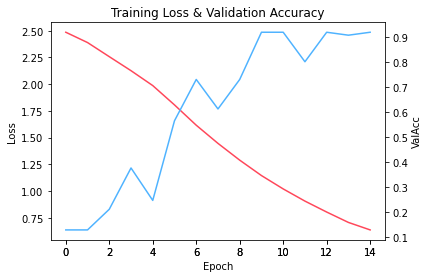

In [19]:
plot_loss_with_acc(loss, val_acc)

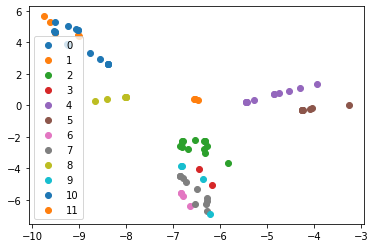

In [20]:
# 绘制测试数据的TSNE降维图
from sklearn.manifold import TSNE
tsne = TSNE()
out = tsne.fit_transform(test_logits)
fig = plt.figure()
for i in range(12):
    indices = test_label == i
    x, y = out[indices].T
    plt.scatter(x, y, label=str(i))
plt.legend()